# Image Captioning

The objective of this project is to build an image captioning model using deep learning techniques. The primary goal is to generate natural language captions for images using a combination of the VGG16 Convolutional Neural Network (CNN) for feature extraction and an LSTM (Long Short-Term Memory) network to process and generate captions. The dataset used is the Flickr8k dataset, which contains 8,000 images along with their corresponding captions. This project involves processing the images, extracting features, preprocessing captions, training a deep learning model, and using it to generate captions for new images.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import numpy as np
import pickle

In [43]:
import os
import json

kaggle_credentials = {"username":"archanasaikannan", "key":"b1685a7f132df278a3e1cc25bbbfd086"}
os.makedirs('/root/.kaggle', exist_ok=True)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json

In [44]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:12<00:00, 152MB/s]
100% 1.04G/1.04G [00:12<00:00, 90.6MB/s]


In [45]:
!unzip flickr8k.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [ ]:
os.listdir('/content/flickr8k')

['captions.txt', 'Images']

## VGG16

- VGG16 is a pre-trained Convolutional Neural Network (CNN) primarily used for image classification.

- It has been trained on ImageNet, which helps the model learn useful visual features such as edges, textures, and object shapes.

- In the case of image captioning, instead of using VGG16 for classification, we repurpose it to extract high-level feature representations of images. These features will then be used to generate captions.

In [ ]:
# Loading the pre-trained VGG16 model
model = VGG16()

# Using VGG16 as a feature extractor:
# Extracting the second-last layer (before the final classification layer) to get high-level features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Displaying the structure of the modified model
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

## Extract Features from Images

- The **VGG16** model is used to extract features from a set of images located in a specified directory. The images are processed and resized to the required input size of VGG16 (224x224 pixels) before passing them through the model.

- **Steps involved:**
  1. Load each image from the directory.
  2. Resize the image to 224x224 pixels (required by VGG16).
  3. Convert the image to a NumPy array for processing.
  4. Reshape the data to match the input shape required by the model.
  5. Preprocess the image for VGG16 using the `preprocess_input` function.
  6. Pass the image through the model to extract its features.
  7. Store the extracted features along with the image ID for later use.

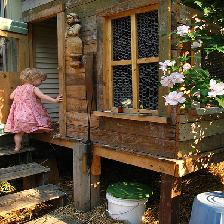

In [ ]:
load_img('/content/flickr8k/Images/1000268201_693b08cb0e.jpg', target_size=(224, 224))

In [ ]:
from tqdm.notebook import tqdm

# Initializing an empty dictionary to store the extracted features
features = {}

# Directory containing the images
directory ='/content/flickr8k/Images'

# Iterating through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))  # Resizing the image to 224x224 pixels
    # Converting the image pixels to a NumPy array (pixels as RGB values)
    image = img_to_array(image)
    # Reshaping the image to fit the model's input shape (1, height, width, channels): (1, 224, 224, 3)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocessing the image for VGG16: normalize pixel values (0-255 to a range the model was trained on)
    image = preprocess_input(image)
    # Extracting high-level features using the VGG16 model
    feature = model.predict(image, verbose=0)
    # Extracting the image ID (name without extension) to use as a key
    image_id = img_name.split('.')[0]
    # Storing the extracted features with the image ID
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
len(features)

8091

In [ ]:
# Saving the features to a pickle file
with open('/content/features.pkl', 'wb') as file:
    pickle.dump(features, file)

In [3]:
# Loading features from pickle for quicker runtime
with open('/content/features.pkl', 'rb') as f:
    features = pickle.load(f)

## Map Images to the Captions

In [ ]:
with open('/content/flickr8k/captions.txt', 'r') as f:
    next(f)     # Skip the first line containing the headers
    captions_doc = f.readlines()

In [ ]:
captions_doc[0]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n'

In [ ]:
captions_doc[0].strip().split(',')[1]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
# Initializing an empty dictionary to store the mapping of image ID to captions
mapping = {}

# Iterating through each caption in the document
for line in tqdm(captions_doc):
    if len(line.strip()) < 2:  # Skip empty lines
        continue

    # Splitting the line by comma, first token is image ID, rest are caption words
    tokens = line.strip().split(',')
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]  # Remove file extension from image ID
    caption = " ".join(caption)  # Join the list of caption words into a single string

    #   Create an empty list if image_id does not exist in mapping
    if image_id not in mapping:
        mapping[image_id] = []

    # Adding the caption to the list of captions for this image ID
    mapping[image_id].append(caption)

  0%|          | 0/40455 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
# Save the mapping dictionary to a pickle file
with open('/content/image_caption_mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [68]:
with open('/content/image_caption_mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

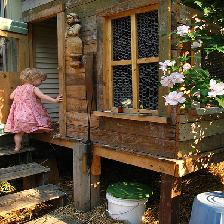

In [ ]:
load_img('/content/flickr8k/Images/1000268201_693b08cb0e.jpg', target_size=(224, 224))

In [69]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [70]:
import re

for key, captions in mapping.items():
    for i in range(len(captions)):
        caption = captions[i]
        caption = caption.lower()   # Convert to lowercase
        caption = re.sub(r'[^a-zA-Z\s]', '', caption)   # Remove non-alphabetic characters (special characters, digits, etc.)
        caption = re.sub(r'\s+', ' ', caption).strip()  # Remove extra spaces (replace multiple spaces with a single space)
        # Add startseq and endseq tokens to mark the beginning and end of the caption
        #   and remove single-letter words that are generally not meaningful for caption generation
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
        captions[i] = caption   # Store the cleaned caption back

In [71]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [72]:
# Storing the preprocessed captions into a list
all_captions = [caption for key in mapping for caption in mapping[key]]
len(all_captions)

40455

In [73]:
all_captions[:10]   # first ten captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Text Preprocessing

In [74]:
# Initialize the Tokenizer to convert text into token indices
tokenizer = Tokenizer()

# Fit the tokenizer on all the captions, learning the word frequencies
tokenizer.fit_on_texts(all_captions)

list(tokenizer.word_index.items())[:10]

[('startseq', 1),
 ('endseq', 2),
 ('in', 3),
 ('the', 4),
 ('on', 5),
 ('is', 6),
 ('and', 7),
 ('dog', 8),
 ('with', 9),
 ('man', 10)]

In [75]:
# Get the vocabulary size (total number of unique words + 1 for padding as Keras' tokenizer uses 1-based indexing)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8768

Vocabulary size (vocab_size) is used to define the size of the model's output layer or the embedding layer in a neural network.

Tokenization and knowing the vocabulary size helps the model to map words to unique numerical values and process them efficiently.

In [76]:
# Get the maximum length of the captions (longest caption in terms of word count)
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

Finding the maximum length of the captions helps to determine the length for padding or truncating all captions to a uniform size. This ensures that all input sequences have the same length when fed into the model, preventing shape mismatches during training.

## Train-Test Split

To split the dataset into training and testing sets. 90% of the image IDs will be used for training, and 10% for testing.

In [77]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

## Model Creation

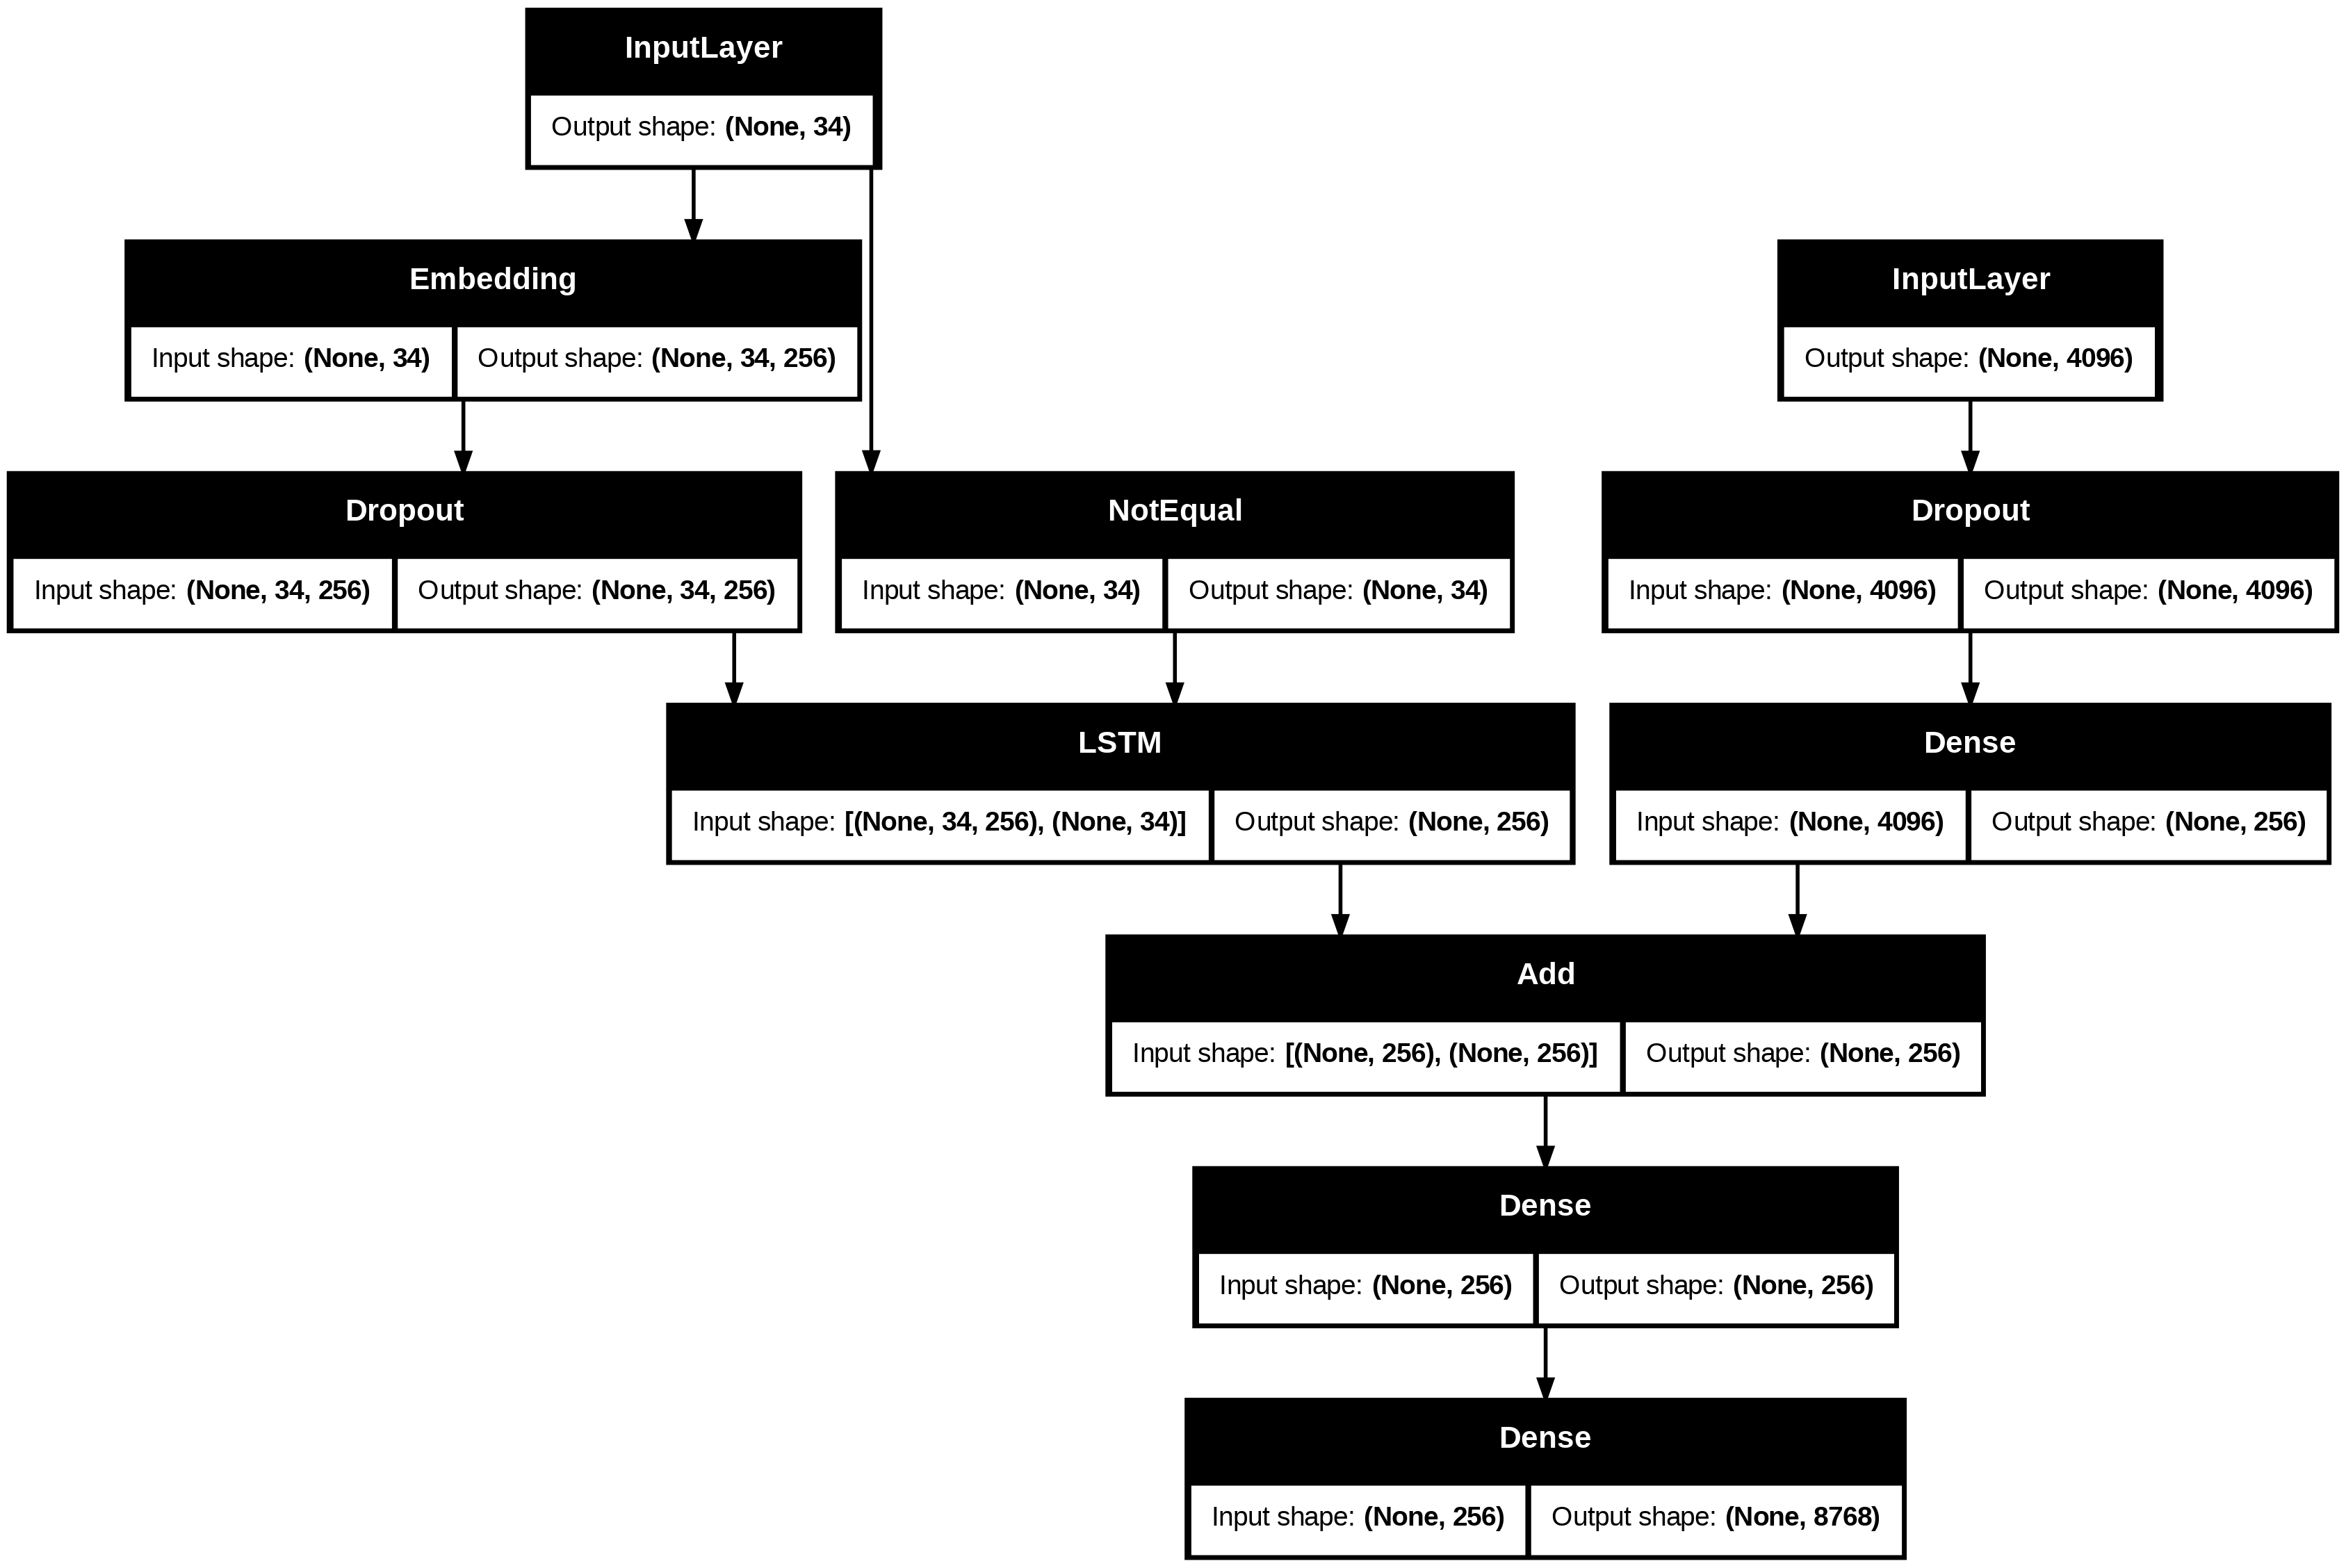

In [78]:
# Encoder model
# Image feature processing
inputs1 = Input(shape=(4096,), name="image")  # Input for image features
fe1 = Dropout(0.4)(inputs1)  # Dropout layer for regularization
fe2 = Dense(256, activation='relu')(fe1)  # Dense layer with ReLU activation

# Sequence feature processing (text/caption)
inputs2 = Input(shape=(max_length,), name="text")  # Input for text (captions)
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  # Embedding layer for word tokens
se2 = Dropout(0.4)(se1)  # Dropout for regularization
se3 = LSTM(256)(se2)  # LSTM layer to process sequences

# Decoder model
decoder1 = add([fe2, se3])  # Combine image and text features
decoder2 = Dense(256, activation='relu')(decoder1)  # Dense layer for further processing
outputs = Dense(vocab_size, activation='softmax')(decoder2)  # Output layer for word probabilities

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)  # Define the model with inputs and outputs
model.compile(loss='categorical_crossentropy', optimizer='adam')  # Compile the model with a loss function and optimizer

# Visualize the model
plot_model(model, show_shapes=True)  # Plot the model architecture with shape details

#### Data Generator for Batch Processing

To define a data generator function that loads and processes image-caption pairs in batches. The generator tokenizes captions, pads sequences, one-hot encodes target words, and yields batches of data for training, making the process memory-efficient and manageable.

In [79]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:  # Infinite loop for the generator
        X1, X2, y = [], [], []  # Initialize lists to store data
        for key in data_keys:
            for caption in mapping[key]:
                seq = tokenizer.texts_to_sequences([caption])[0]  # Tokenize caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # Input-output pair
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]  # Pad input
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  # One-hot encode output
                    X1.append(features[key][0])  # Image features
                    X2.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output word
                if len(X1) >= batch_size:  # When batch is full
                    yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)  # Yield batch
                    X1, X2, y = [], [], []  # Reset lists

        # Yield any remaining data if it's not a full batch
        if len(X1) > 0:  # If there are still items left
            yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)

In [80]:
# Fit the model using the data generator
history = model.fit(
    data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size=64),  # Data generator for batch processing
    steps_per_epoch=len(train) // 64,  # Number of steps per epoch (total images / batch size)
    epochs=20,  # Number of epochs to train the model
    verbose=1  # Display training progress
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 311ms/step - loss: 6.8828
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 340ms/step - loss: 5.7039
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 316ms/step - loss: 5.5745
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - loss: 5.3607
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 320ms/step - loss: 5.2898
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 314ms/step - loss: 5.1691
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 333ms/step - loss: 5.0580
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - loss: 4.9357
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 316ms/step - loss: 4.8118
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 317ms/step - loss: 4.5957
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 318ms/step - loss: 4.4883
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 321ms/step - loss: 4.7046
Epoch 13/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 312ms/step - loss: 4.4977
Epoch 14/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 315ms/step - loss: 4.4459
Epoch 15/20
113

In [81]:
# Save the model
model.save('/content/Image_Captioning_model.keras')

## Generate Captions for Images

In [82]:
# Convert index to word
def idx_to_word(integer, tokenizer):
    # Iterate over the tokenizer's word index to find the word matching the given index
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [92]:
# Function to generate the caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'  # Starting token
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]  # Convert to sequence of tokens
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')  # Pad the sequence
        yhat = model.predict([image, sequence], verbose=0)  # Predict the next word
        yhat = np.argmax(yhat)  # Get the index with the highest probability
        word = idx_to_word(yhat, tokenizer)  # Convert index to word
        if word is None:  # If no word is found, stop
            break
        in_text += ' ' + word  # Append the predicted word to the input text
        if word == 'endseq':  # Stop when the end token is reached
            break
    return in_text

In [95]:
from PIL import Image
import matplotlib.pyplot as plt

def caption_comparison(image_name):
    image_id = image_name.split('.')[0]
    img_path = '/content/flickr8k/Images/' + image_name
    image = Image.open(img_path)

    # Display the actual captions for comparison
    captions = mapping[image_id]
    print('\n---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Generate the predicted caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('\n--------------------Predicted--------------------')
    print(y_pred, end='\n\n')

    # Display the image
    plt.imshow(image)
    plt.show()


---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq

--------------------Predicted--------------------
startseq dog is running on the grass endseq



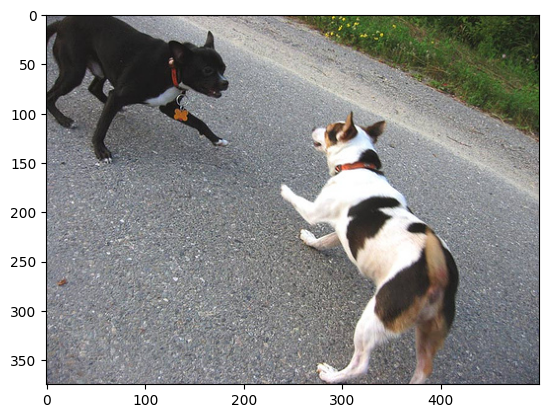

In [96]:
caption_comparison('1001773457_577c3a7d70.jpg')